In [1]:
import os
import cv2
import sys
import torch
import mmcv
import numpy as np
import pickle as pkl
import os.path as osp
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import matplotlib.patches as patches
from scipy.io import loadmat
from scipy.spatial.transform import Rotation as R
from mmcv import Config, DictAction

In [2]:
def get_split_dict(path_split):
    # ./tools/train_test_splitter
    f = open(path_split, 'r')
    lines = f.readlines()
    f.close
    dict_seq = dict()
    for line in lines:
        seq = line.split(',')[0]
        label = line.split(',')[1].split('.')[0]
        if not (seq in list(dict_seq.keys())):
            dict_seq[seq] = []
        dict_seq[seq].append(label)
    return dict_seq

## 0. Prepare Data Path

In [3]:
data_path = '/mnt/weka/scratch/yang.liu3/pyworkspace/EchoFusion/data/k-radar'
path_split = osp.join(data_path, 'ImageSets/test.txt')
dict_split = get_split_dict(path_split)

seq_idx, sample_idx = '1', 280
path_attr = osp.join(data_path, seq_idx)
sample_idx_list = dict_split[seq_idx]
idx_name = sample_idx_list[sample_idx]
print(f"Use sample {sample_idx}/{len(sample_idx_list)}")

# read sample filename of each modality
path_label = osp.join(path_attr, 'info_label', f'{idx_name}.txt')
print(path_label)
f = open(path_label, 'r')
lines = f.readlines()
header = lines[0]
indices = ((header.split(',')[0]).split('=')[1]).split('_')
timestamp = float(((header.split(',')[1]).split('=')[1]).rstrip('\n'))
idx_rdr, idx_os64, idx_cam_front, idx_os128, idx_cam_lrr = indices

# load sample
path_img = osp.join(path_attr, 'cam-front', f'cam-front_{idx_cam_front}.png')
path_pcd = osp.join(path_attr, 'os2-64', f'os2-64_{idx_os64}.pcd')
path_cube = osp.join(path_attr, 'radar_zyx_cube', f'cube_{idx_rdr}.mat')
path_sp_cube = osp.join(path_attr, 'sp_rdr_cube', f'spcube_{idx_rdr}.npy')
path_calib = osp.join(path_attr, 'info_calib', f'calib_radar_lidar.txt')
print(f'cam-front_{idx_cam_front}.png')

Use sample 280/299
/mnt/weka/scratch/yang.liu3/pyworkspace/EchoFusion/data/k-radar/1/info_label/00611_00579.txt
cam-front_01736.png


In [4]:
line_objects = lines[1:]
list_objects, offset = [], 1
for line in line_objects:
    list_values = line.split(',')
    if list_values[0] != '*':
        continue

    x = float(list_values[3+offset])
    y = float(list_values[4+offset])
    z = float(list_values[5+offset])
    theta = float(list_values[6+offset])
    l = 2*float(list_values[7+offset])
    w = 2*float(list_values[8+offset])
    h = 2*float(list_values[9+offset])
    temp_tuple = (x, y, z, theta, l, w, h)

    if temp_tuple is not None:
        list_objects.append(temp_tuple)
array_objects = np.array(list_objects)

## 1. Show Image and LiDAR

In [5]:
def calc_3dbbox(loc, dim, yaw):
    l = dim[0]
    w = dim[1]
    h = dim[2]
    r = yaw
    loc = loc.copy()
    loc[2] += h/2
    R = np.array([[np.cos(r), -np.sin(r), 0],
                  [np.sin(r), np.cos(r), 0],
                  [0, 0, 1]])

    corners = np.array([[l / 2, l / 2, -l / 2, -l / 2, l / 2, l / 2, -l / 2, -l / 2],
                        [w / 2, -w / 2, -w / 2, w / 2, w / 2, -w / 2, -w / 2, w / 2],
                        [-h / 2, -h / 2, -h / 2, -h / 2, h / 2, h / 2, h / 2, h / 2]])

    corners_rot = np.dot(R, corners) + loc[None, :].T
    return  np.transpose(corners_rot, (1, 0))

In [6]:
# Set intrinsic and extrinsic matrix
img_size = (1280,720)
dict_values = {
    'fx':557.720776478944,
    'fy':567.2136917114258,
    'px':636.720776478944,
    'py':369.3068656921387,
    'k1':-0.028873818023371287,
    'k2':0.0006023302214797655,
    'k3':0.0039573086622276855,
    'k4':-0.005047176298643093,
    'k5':0.0,
    'roll_c':0.0,
    'pitch_c':0.0,
    'yaw_c':0.0,
    'roll_l':0.0,
    'pitch_l':0.7,
    'yaw_l':-0.5,
    'x_l':0.1,
    'y_l':0.0,
    'z_l':-0.7
}
tr_rotation_default = np.array([
    [0.0, -1.0, 0.0, 0.0],
    [0.0, 0.0, -1.0, 0.0],
    [1.0, 0.0, 0.0, 0.0],
    [0.0, 0.0, 0.0, 1.0]
])
intrinsics = np.array([
    [dict_values['fx'], 0.0, dict_values['px']],
    [0.0, dict_values['fy'], dict_values['py']],
    [0.0, 0.0, 1.0]
])
distortion = np.array([
    dict_values['k1'], dict_values['k2'], dict_values['k3'], \
    dict_values['k4'], dict_values['k5']
]).reshape((-1,1))
yaw_c = dict_values['yaw_c']
pitch_c = dict_values['pitch_c']
roll_c = dict_values['roll_c']
r_cam = (R.from_euler('zyx', [yaw_c, pitch_c, roll_c], degrees=True)).as_matrix()
yaw_l = dict_values['yaw_l']
pitch_l = dict_values['pitch_l']
roll_l = dict_values['roll_l']
r_l = (R.from_euler('zyx', [yaw_l, pitch_l, roll_l], degrees=True)).as_matrix()
x_l = dict_values['x_l']
y_l = dict_values['y_l']
z_l = dict_values['z_l']
tr_lid_cam = np.concatenate([r_l, np.array([x_l,y_l,z_l]).reshape(-1,1)], axis=1)
ncm, _ = cv2.getOptimalNewCameraMatrix(intrinsics, distortion, img_size, alpha=0.0)
for j in range(3):
    for i in range(3):
        intrinsics[j,i] = ncm[j, i]
map_x, map_y = cv2.initUndistortRectifyMap(intrinsics, distortion, r_cam, ncm, img_size, cv2.CV_32FC1)
P2 = np.insert(intrinsics, 3, values=[0,0,0], axis=1) # K = intrinsics
R0_hom = r_cam
R0_hom = np.insert(R0_hom,3,values=[0,0,0],axis=0)
R0_hom = np.insert(R0_hom,3,values=[0,0,0,1],axis=1) # 4x4
LidarToCamera = np.insert(tr_lid_cam, 3, values=[0,0,0,1], axis=0)
proj = np.matmul(np.matmul(P2,R0_hom),np.matmul(LidarToCamera, tr_rotation_default))

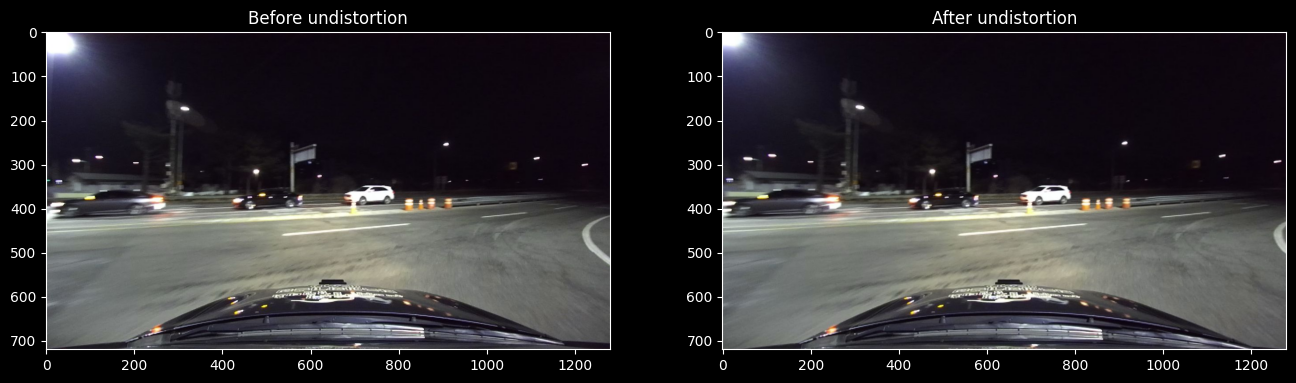

In [7]:
# Show Image
dist_cam = cv2.imread(path_img)[:,:1280,[2,1,0]].copy()
vis_cam = cv2.remap(dist_cam, map_x, map_y, cv2.INTER_LINEAR)
# show dist_cam and vis_cam respectively
plt.figure(figsize=(16,8))
ax1 = plt.subplot(1,2,1)
ax1.set_title('Before undistortion')
plt.imshow(dist_cam)
ax2 = plt.subplot(1,2,2)
ax2.set_title('After undistortion')
plt.imshow(vis_cam)

In [8]:
# Show LiDAR
pc_lidar = []
with open(path_pcd, 'r') as f:
    lines = [line.rstrip('\n') for line in f][13:]
    pc_lidar = [point.split() for point in lines]
    f.close()
pc_lidar = np.array(pc_lidar, dtype=float).reshape(-1, 9)[:, :4]
# 0.01: filter out missing values
pc_lidar = pc_lidar[np.where(pc_lidar[:, 0] > 0.01)].reshape(-1, 4)
print("Shape of point cloud: ", pc_lidar.shape)

Shape of point cloud:  (36910, 4)


[[ 1.3740e+01  1.1890e+01 -1.0000e-01  1.1769e+02  5.0200e+00  2.7000e+00
   2.1000e+00]
 [ 1.8060e+01  3.9000e+00  0.0000e+00  1.1945e+02  4.5800e+00  2.2900e+00
   1.9000e+00]
 [ 2.2100e+01 -4.0500e+00  2.0000e-01  1.1701e+02  5.0600e+00  2.6500e+00
   2.1000e+00]]


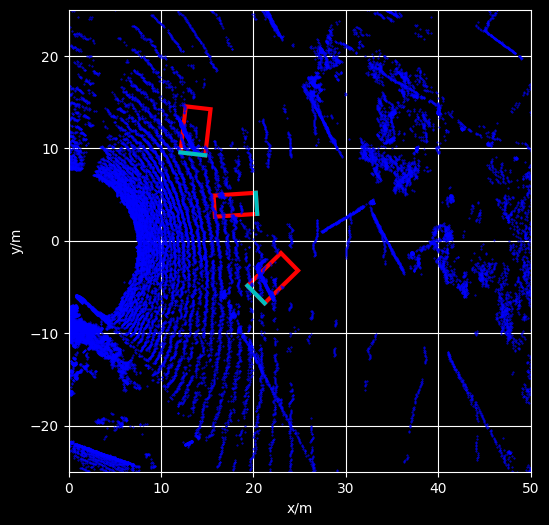

In [9]:
gt_loc = array_objects[:, :3]
gt_dim = array_objects[:, 4:7]
gt_yaw = array_objects[:, 3]
print(np.around(array_objects,2))

fig = plt.figure(figsize=(12, 6))
ax = fig.add_subplot(1,1,1)
ax.set_aspect('equal')
ax.plot(pc_lidar[:, 0], pc_lidar[:, 1], 'b.', markersize=0.8)
for i in range(array_objects.shape[0]):
    bbox3d = calc_3dbbox(gt_loc[i], gt_dim[i], gt_yaw[i])
    rect=patches.Polygon(bbox3d[:4,:2],linewidth=3,edgecolor='r',facecolor='none')
    rect.set_zorder(1)
    ax.plot(bbox3d[[0,1],0], bbox3d[[0,1],1], 'c-', linewidth=3)
    ax.add_patch(rect)

plt.xlim(0, 50)
plt.xlabel('x/m')
plt.ylim(-25,25)
plt.ylabel('y/m')
plt.grid()
plt.style.use('default')

Text(0.5, 1.0, '3D points projected onto camera image')

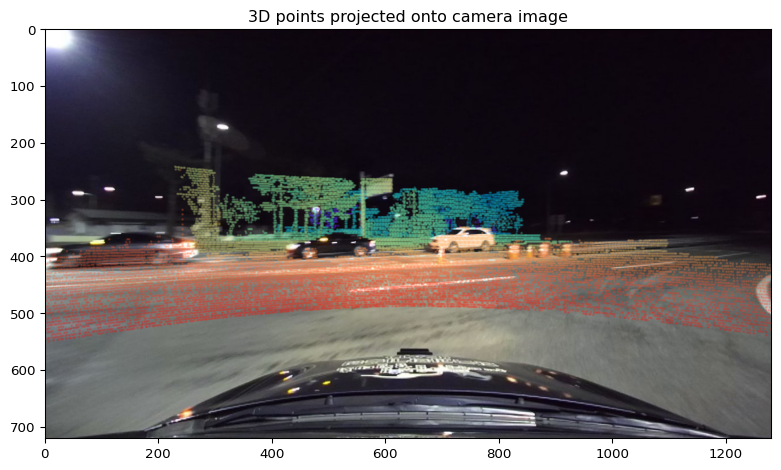

In [10]:
# Project PCD on Image
x_min, x_max, y_min, y_max, z_min, z_max = 0, 72.0, -20, 20, -2, 8
points_roi = np.array(list(filter(lambda x: (x[0]>x_min) and (x[0]<x_max) \
                and (x[1]>y_min) and (x[1]<y_max) and (x[2]>z_min) and (x[2]<z_max), pc_lidar.tolist())))
points_hom = np.transpose(points_roi[:,:3].copy(), (1,0))
points_hom = np.insert(points_hom, 3, 1, axis=0)
cam_3d = np.matmul(proj, points_hom)
cam_3d[:2] /= cam_3d[2,:]
cam_3d = np.around(cam_3d).astype(int)
mask = np.logical_and(np.logical_and(cam_3d[0,:] >= 0, cam_3d[0,:] < img_size[0]), \
                        np.logical_and(cam_3d[1,:] >= 0, cam_3d[1,:] < img_size[1]))
cam_3d = cam_3d[:, mask]
u,v,z = cam_3d

# show cam_3d
plt.figure(figsize=(12,5),dpi=96,tight_layout=True)
IMG_H,IMG_W,_ = vis_cam.shape
plt.axis([0,IMG_W,IMG_H,0])
plt.imshow(vis_cam)
plt.scatter([u],[v],c=[z],cmap='rainbow_r',alpha=0.2,s=1)
plt.title(f"3D points projected onto camera image")

## 2. Show Radar Data

In [11]:
arr_cube = np.flip(loadmat(path_cube)['arr_zyx'], axis=0) # z-axis is flipped  # [150, 400, 250]
Z, Y, X = arr_cube.shape
z_inds, y_inds, x_inds = np.where(arr_cube != -1)
pw = 10*np.log10(arr_cube[z_inds, y_inds, x_inds])
radar_pcd = np.stack([x_inds, y_inds, z_inds, pw], axis=1)
radar_pcd[:, 0] = (radar_pcd[:, 0] / X) * 100
radar_pcd[:, 1] = (radar_pcd[:, 1] / Y) * 160 - 80
radar_pcd[:, 2] = (radar_pcd[:, 2] / Z) * 60 - 30
rho = np.sqrt(np.sum(radar_pcd[:, :2] ** 2, axis=1))  # 0.0 ~ 118.0
phi = np.arctan2(radar_pcd[:, 1], radar_pcd[:, 0])  # -53.0 ~ 53.0
z = radar_pcd[:, 2]
polar_pcd = np.stack([rho, phi, z, pw], axis=1)

print(f"Min and Max radius: {np.min(rho)} m, {np.max(rho)} m")
print(f"Min and Max azimuth: {np.min(phi)} rad, {np.max(phi)} rad")
print(f"Min and Max height: {np.min(z)} m, {np.max(z)} m")

Min and Max radius: 0.4 m, 118.01694793545543 m
Min and Max azimuth: -0.924980407321327 rad, 0.9249804073213269 rad
Min and Max height: -30.0 m, 29.599999999999994 m


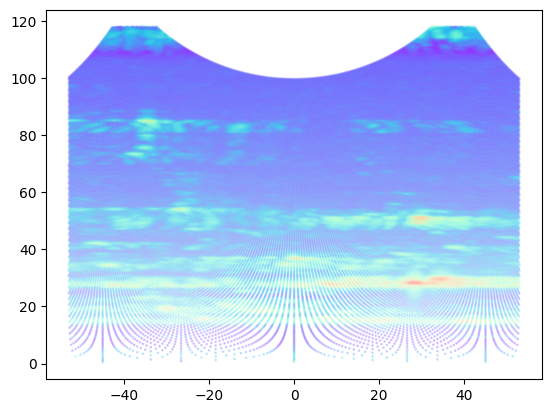

In [12]:
arr_bev = np.max(arr_cube, axis=0)
Y, X = arr_bev.shape
y_inds, x_inds = np.where(arr_bev != -1)
pw = 10*np.log10(arr_bev[y_inds, x_inds])
radar_pcd = np.stack([x_inds, y_inds, pw], axis=1)
radar_pcd[:, 0] = (radar_pcd[:, 0] / X) * 100
radar_pcd[:, 1] = (radar_pcd[:, 1] / Y) * 160 - 80
rho = np.sqrt(np.sum(radar_pcd[:, :2] ** 2, axis=1))  # 0.0 ~ 118.0
phi = np.arctan2(radar_pcd[:, 1], radar_pcd[:, 0]) * 180 / np.pi # -53.0 ~ 53.0
plt.figure()
plt.scatter(phi, rho, c=pw, cmap='rainbow', alpha=0.2, s=1)

/root/anaconda3/envs/mmdet3d/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: divide by zero encountered in log10
  


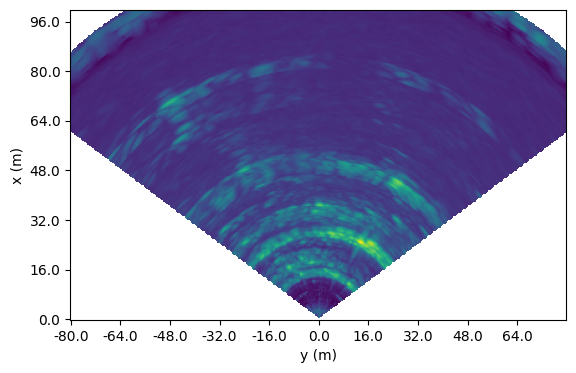

In [14]:
arr_z_cb = np.arange(-30, 30, 0.4)
arr_y_cb = np.arange(-80, 80, 0.4)  # 400
arr_x_cb = np.arange(0, 100, 0.4)  # 250
# x_min, x_max, y_min, y_max, z_min, z_max = 0, 98.8, -40, 40, -2, 5.6
# arr_cube_roi = np.array(list(filter(lambda x: (x[2]>x_min) and (x[2]<x_max) \
#                 and (x[1]>y_min) and (x[1]<y_max) and (x[0]>z_min) and (x[0]<z_max), arr_cube.tolist())))
arr_cube[np.where(arr_cube==-1.)]= 1.
arr_cube = 10*np.log10(arr_cube)
# arr_cube_bev = np.max(arr_cube, axis=0)
arr_cube_bev = np.transpose(np.max(arr_cube, axis=0), (1,0))
# arr_cube_bev = np.flip(arr_cube_bev, axis=1)
# visualize the cube
interval = 40
plt.yticks(np.arange(0, len(arr_x_cb), interval), np.around(arr_x_cb[np.arange(0, len(arr_x_cb), interval)], 1));
plt.xticks(np.arange(0, len(arr_y_cb), interval), np.around(arr_y_cb[np.arange(0, len(arr_y_cb), interval)], 1));
plt.ylabel('x (m)')
plt.xlabel('y (m)')
plt.imshow(arr_cube_bev, origin='lower')

Text(0.5, 1.0, 'Sparse Cube Projected to BEV')

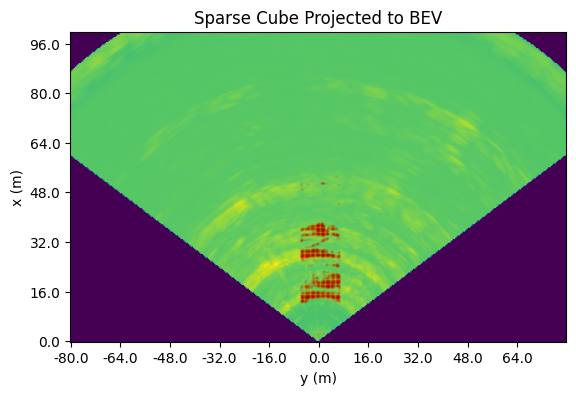

In [46]:
plt.yticks(np.arange(0, len(arr_x_cb), interval), np.around(arr_x_cb[np.arange(0, len(arr_x_cb), interval)], 1));
plt.xticks(np.arange(0, len(arr_y_cb), interval), np.around(arr_y_cb[np.arange(0, len(arr_y_cb), interval)], 1));
plt.ylabel('x (m)')
plt.xlabel('y (m)')
plt.imshow(arr_cube_bev, origin='lower')
0
spcube = np.load(path_sp_cube)  # [x,y,z,power]
spcube_xbin = spcube[:,0] / 0.4
spcube_ybin = (-spcube[:,1] + 80) / 0.4
plt.scatter(spcube_ybin, spcube_xbin, c='r', alpha=0.01, s=1)
plt.title(f"Sparse Cube Projected to BEV")

[-2.54  0.3   0.  ]


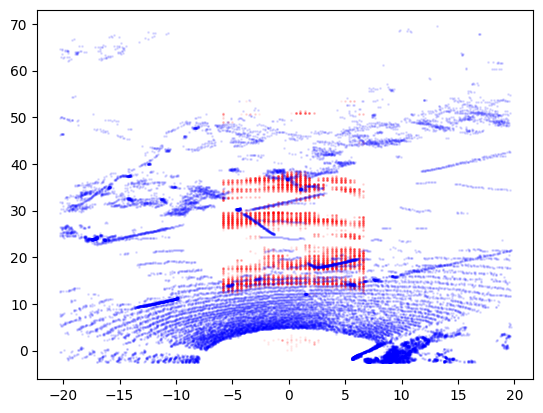

In [47]:
with open(path_calib) as f:
    lines = f.readlines()
    f.close()
list_calib = list(map(lambda x: float(x), lines[1].split(',')))
# list_calib[0] # frame difference
list_values = [list_calib[1], list_calib[2], 0.] # X, Y, Z
calib_info = np.array(list_values)
print(calib_info)

plt.scatter(-spcube[:,1], spcube[:,0], c='r', alpha=0.05, s=1)
plt.scatter(-(points_roi[:,1]+calib_info[1]), points_roi[:,0]+calib_info[0], c='b', alpha=0.1, s=1)